# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [1]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

### Load agemoea2 results for all topos

In [2]:
with open('res_bc_Cogent_agemoea2.pkl','rb') as f_Cogent:
    res_2_Cogent = pickle.load(f_Cogent)
with open('res_bc_UsCarrier_agemoea2.pkl','rb') as f_UsCarrier:
    res_2_UsCarrier = pickle.load(f_UsCarrier)
with open('res_bc_HiberniaGlobal_agemoea2.pkl','rb') as f_HiberniaGlobal:
    res_2_HiberniaGlobal = pickle.load(f_HiberniaGlobal)
with open('res_bc_Colt_agemoea2.pkl','rb') as f_Colt:
    res_2_Colt = pickle.load(f_Colt)
with open('res_bc_Funet_agemoea2.pkl','rb') as f_Funet:
    res_2_Funet = pickle.load(f_Funet)
with open('res_bc_Abvt_agemoea2.pkl','rb') as f_Abvt:
    res_2_Abvt = pickle.load(f_Abvt)
with open('res_bc_Intellifiber_agemoea2.pkl','rb') as f_Intellifiber:
    res_2_Intellifiber = pickle.load(f_Intellifiber)
with open('res_bc_TataNld_agemoea2.pkl','rb') as f_TataNld:
    res_2_TataNld = pickle.load(f_TataNld)
with open('res_bc_Internode_agemoea2.pkl','rb') as f_Internode:
    res_2_Internode = pickle.load(f_Internode)
with open('res_bc_Missouri_agemoea2.pkl','rb') as f_Missouri:
    res_2_Missouri = pickle.load(f_Missouri)
with open('res_bc_Ion_agemoea2.pkl','rb') as f_Ion:
    res_2_Ion = pickle.load(f_Ion)
with open('res_bc_Palmetto_agemoea2.pkl','rb') as f_Palmetto:
    res_2_Palmetto = pickle.load(f_Palmetto)

## Hypervolume
1. Store values

In [3]:

# agemoea2
F2_Cogent=res_2_Cogent.F
F2_UsCarrier=res_2_UsCarrier.F
F2_HiberniaGlobal=res_2_HiberniaGlobal.F
F2_Colt=res_2_Colt.F
F2_Funet=res_2_Funet.F
F2_Abvt=res_2_Abvt.F
F2_Intellifiber=res_2_Intellifiber.F
F2_TataNld=res_2_TataNld.F
F2_Internode=res_2_Internode.F
F2_Missouri=res_2_Missouri.F
F2_Ion=res_2_Ion.F
F2_Palmetto=res_2_Palmetto.F

# # Nadir Point from 9 Algorithms: 
# ref_point = [1.81000000e+02 6.20000000e+01 3.92281875e+03 1.70537209e+00]
# # Nadir Point from 4 Algorithms: 
# ref_point = [160.  77.  inf  inf]
# # Nadir Point from all (13) Algorithms: 
# ref_point = [181.  77.  inf  inf]

ref_point = [181, 77, 3922.81875, 1.70537209]

hist_F2_Cogent = []
hist_F2_UsCarrier = []
hist_F2_HiberniaGlobal = []
hist_F2_Colt = []
hist_F2_Funet = []
hist_F2_Abvt = []
hist_F2_Intellifiber = []
hist_F2_TataNld = []
hist_F2_Internode = []
hist_F2_Missouri = []
hist_F2_Ion = []
hist_F2_Palmetto = []


for algo2_Cogent in res_2_Cogent.history:
    opt2_Cogent = algo2_Cogent.opt
    feas2_Cogent = np.where(opt2_Cogent.get("feasible"))[0]
    hist_F2_Cogent.append(opt2_Cogent.get("F")[feas2_Cogent])
for algo2_UsCarrier in res_2_UsCarrier.history:
    opt2_UsCarrier = algo2_UsCarrier.opt
    feas2_UsCarrier = np.where(opt2_UsCarrier.get("feasible"))[0]
    hist_F2_UsCarrier.append(opt2_UsCarrier.get("F")[feas2_UsCarrier])
for algo2_HiberniaGlobal in res_2_HiberniaGlobal.history:
    opt2_HiberniaGlobal = algo2_HiberniaGlobal.opt
    feas2_HiberniaGlobal = np.where(opt2_HiberniaGlobal.get("feasible"))[0]
    hist_F2_HiberniaGlobal.append(opt2_HiberniaGlobal.get("F")[feas2_HiberniaGlobal])
for algo2_Colt in res_2_Colt.history:
    opt2_Colt = algo2_Colt.opt
    feas2_Colt = np.where(opt2_Colt.get("feasible"))[0]
    hist_F2_Colt.append(opt2_Colt.get("F")[feas2_Colt])
for algo2_Funet in res_2_Funet.history:
    opt2_Funet = algo2_Funet.opt
    feas2_Funet = np.where(opt2_Funet.get("feasible"))[0]
    hist_F2_Funet.append(opt2_Funet.get("F")[feas2_Funet])
for algo2_Abvt in res_2_Abvt.history:
    opt2_Abvt = algo2_Abvt.opt
    feas2_Abvt = np.where(opt2_Abvt.get("feasible"))[0]
    hist_F2_Abvt.append(opt2_Abvt.get("F")[feas2_Abvt])
for algo2_Intellifiber in res_2_Intellifiber.history:
    opt2_Intellifiber = algo2_Intellifiber.opt
    feas2_Intellifiber = np.where(opt2_Intellifiber.get("feasible"))[0]
    hist_F2_Intellifiber.append(opt2_Intellifiber.get("F")[feas2_Intellifiber])
for algo2_TataNld in res_2_TataNld.history:
    opt2_TataNld = algo2_TataNld.opt
    feas2_TataNld = np.where(opt2_TataNld.get("feasible"))[0]
    hist_F2_TataNld.append(opt2_TataNld.get("F")[feas2_TataNld])
for algo2_Internode in res_2_Internode.history:
    opt2_Internode = algo2_Internode.opt
    feas2_Internode= np.where(opt2_Internode.get("feasible"))[0]
    hist_F2_Internode.append(opt2_Internode.get("F")[feas2_Internode])
for algo2_Missouri in res_2_Missouri.history:
    opt2_Missouri = algo2_Missouri.opt
    feas2_Missouri = np.where(opt2_Missouri.get("feasible"))[0]
    hist_F2_Missouri.append(opt2_Missouri.get("F")[feas2_Missouri])
for algo2_Ion in res_2_Ion.history:
    opt2_Ion = algo2_Ion.opt
    feas2_Ion = np.where(opt2_Ion.get("feasible"))[0]
    hist_F2_Ion.append(opt2_Ion.get("F")[feas2_Ion])
for algo2_Palmetto in res_2_Palmetto.history:
    opt2_Palmetto = algo2_Palmetto.opt
    feas2_Palmetto = np.where(opt2_Palmetto.get("feasible"))[0]
    hist_F2_Palmetto.append(opt2_Palmetto.get("F")[feas2_Palmetto])

2. Calculate hypervolume and merge them (Mean value) for agemoea2 algorithm

In [4]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array(ref_point))

hv_2_Cogent = [metric.do(_F2_Cogent) for _F2_Cogent in hist_F2_Cogent]
hv_2_UsCarrier = [metric.do(_F2_UsCarrier) for _F2_UsCarrier in hist_F2_UsCarrier]
hv_2_HiberniaGlobal = [metric.do(_F2_HiberniaGlobal) for _F2_HiberniaGlobal in hist_F2_HiberniaGlobal]
hv_2_Colt = [metric.do(_F2_Colt) for _F2_Colt in hist_F2_Colt]
hv_2_Funet = [metric.do(_F2_Funet) for _F2_Funet in hist_F2_Funet]
hv_2_Abvt = [metric.do(_F2_Abvt) for _F2_Abvt in hist_F2_Abvt]
hv_2_Intellifiber = [metric.do(_F2_Intellifiber) for _F2_Intellifiber in hist_F2_Intellifiber]
hv_2_TataNld = [metric.do(_F2_TataNld) for _F2_TataNld in hist_F2_TataNld]
hv_2_Internode = [metric.do(_F2_Internode) for _F2_Internode in hist_F2_Internode]
hv_2_Missouri = [metric.do(_F2_Missouri) for _F2_Missouri in hist_F2_Missouri]
hv_2_Ion = [metric.do(_F2_Ion) for _F2_Ion in hist_F2_Ion]
hv_2_Palmetto = [metric.do(_F2_Palmetto) for _F2_Palmetto in hist_F2_Palmetto]

# agemoea2
hv_2 = [(hv_Cogent + hv_UsCarrier + hv_HiberniaGlobal + hv_Colt + hv_Funet + hv_Abvt + hv_Intellifiber + hv_TataNld + hv_Internode + hv_Missouri + hv_Ion + hv_Palmetto) / 12 for hv_Cogent, hv_UsCarrier, hv_HiberniaGlobal, hv_Colt, hv_Funet, hv_Abvt, hv_Intellifiber, hv_TataNld, hv_Internode, hv_Missouri, hv_Ion, hv_Palmetto in zip(hv_2_Cogent, hv_2_UsCarrier, hv_2_HiberniaGlobal, hv_2_Colt, hv_2_Funet, hv_2_Abvt, hv_2_Intellifiber, hv_2_TataNld, hv_2_Internode, hv_2_Missouri, hv_2_Ion, hv_2_Palmetto)]

The hypervolumn for Cogent:
[0.0, 1172249.3785155192, 1174161.644543177, 1699947.8390635948, 1720592.2390842147, 2693306.307118635, 2761077.137808807, 3309462.3639799748, 3489018.230102457, 5312995.558443196, 5991999.2950614635, 5596982.609608472, 6226577.771905117, 6306226.954921858, 7205688.6108324975, 9439806.940710304, 9741043.651879407, 9849957.690015914, 10248135.41745186, 10549143.131565684, 10578925.548410786, 11527217.919850536, 13993600.852436198, 14000313.408784417, 14055322.619355865, 14086563.109554397, 14320618.579386506, 14379915.401266595, 14878117.880096413, 15416003.840677578, 15539621.643746926, 15574130.993721426, 15545918.362851735, 15554958.69079139, 15768689.503663868, 16327281.851172525, 16500819.89529139, 17159052.857072007, 17224206.51502083, 17818672.990756318, 18041119.870784603, 18199599.03369267, 18747243.14945395, 18832835.922490314, 18932870.62369298, 20089097.908947434, 20223622.773675814, 20258672.040266305, 20946283.310205843, 20833847.27909914, 21046

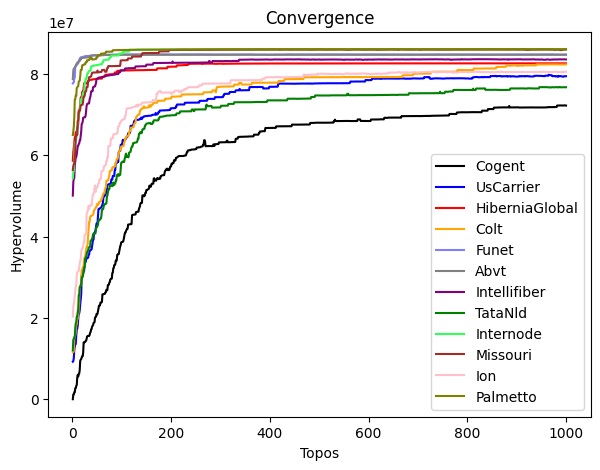

In [5]:
print('The hypervolumn for Cogent:')
print(hv_2_Cogent)
print('The hypervolumn for UsCarrier:')
print(hv_2_UsCarrier)
print('The hypervolumn for HiberniaGlobal:')
print(hv_2_HiberniaGlobal)
print('The hypervolumn for Colt:')
print(hv_2_Colt)
print('The hypervolumn for Funet:')
print(hv_2_Funet)
print('The hypervolumn for Abvt:')
print(hv_2_Abvt)
print('The hypervolumn for Intellifiber:')
print(hv_2_Intellifiber)
print('The hypervolumn for TataNld:')
print(hv_2_TataNld)
print('The hypervolumn for Internode:')
print(hv_2_Internode)
print('The hypervolumn for Missouri:')
print(hv_2_Missouri)
print('The hypervolumn for Ion:')
print(hv_2_Ion)
print('The hypervolumn for Palmetto:')
print(hv_2_Palmetto)

# Show all hv for each topo
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_2_Cogent)+1)), hv_2_Cogent,  color='black', label='Cogent')
plt.plot(list(range(1, len(hv_2_UsCarrier)+1)), hv_2_UsCarrier,  color='blue', label='UsCarrier')
plt.plot(list(range(1, len(hv_2_HiberniaGlobal)+1)), hv_2_HiberniaGlobal,  color='red', label='HiberniaGlobal')
plt.plot(list(range(1, len(hv_2_Colt)+1)), hv_2_Colt,  color='orange', label='Colt')
plt.plot(list(range(1, len(hv_2_Funet)+1)), hv_2_Funet,  color=(0, 0, 1, 0.5), label='Funet')
plt.plot(list(range(1, len(hv_2_Abvt)+1)), hv_2_Abvt,  color='gray', label='Abvt')
plt.plot(list(range(1, len(hv_2_Intellifiber)+1)), hv_2_Intellifiber,  color='purple', label='Intellifiber')
plt.plot(list(range(1, len(hv_2_TataNld)+1)), hv_2_TataNld,  color='green', label='TataNld')
plt.plot(list(range(1, len(hv_2_Internode)+1)), hv_2_Internode,  color='#33FF57', label='Internode')
plt.plot(list(range(1, len(hv_2_Missouri)+1)), hv_2_Missouri,  color='brown', label='Missouri')
plt.plot(list(range(1, len(hv_2_Ion)+1)), hv_2_Ion,  color='pink', label='Ion')
plt.plot(list(range(1, len(hv_2_Palmetto)+1)), hv_2_Palmetto,  color='olive', label='Palmetto')
plt.title("Convergence")
plt.xlabel("Topos")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [6]:
print('The aveage of hypervolumn for agemoea2:')
print(hv_2)

The aveage of hypervolumn for agemoea2:
[41148950.92660948, 42631174.00221274, 43116455.029976614, 44423094.880384095, 45756640.45856065, 46739050.09996308, 47606021.1899713, 48088542.899760626, 48895192.059274375, 49489177.3982565, 50340974.59366187, 50894343.23259515, 52094649.53614854, 52403996.8196306, 53335982.911885016, 54082712.98904463, 54804978.50697719, 55263019.22516978, 56366906.019064575, 56661611.2945945, 56872159.77284845, 57283413.14596663, 57894993.16588802, 58212284.68325061, 58772846.78956423, 59091470.55346537, 59392471.13956034, 59674278.57865473, 60412559.979354255, 60721434.84315438, 60850504.78133833, 61217758.326993056, 61608517.19279096, 61809791.38310212, 62094337.1960055, 62330933.408742875, 62573484.411721736, 62835716.30866448, 62906966.864934586, 63122103.89293588, 63393615.4942274, 63656859.918088265, 63786597.195413284, 64005512.10163108, 64124564.53383566, 64342033.24802043, 64320277.39266107, 64629031.07415551, 64893859.48069718, 64977070.32065036, 65

3. Draw mean hypervolume for agemoea2

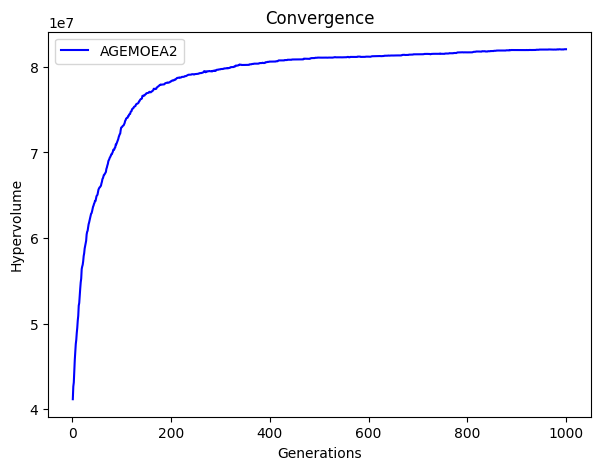

In [7]:
import matplotlib.pyplot as plt

#  Show all alogrithms' hv into a single figure
plt.figure(figsize=(7, 5))
# plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
# plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
# plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
# plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
# plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
# plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
# plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
# plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
# plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
# plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
# plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
# plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations") # brown,pink,#5733FF,olive,cyan,#FF5733,#33FF57
plt.ylabel("Hypervolume")
plt.legend()
plt.show()